In [18]:
import timm
import torch
from torchvision.utils import save_image 
from sklearn.metrics import roc_curve, auc, confusion_matrix,f1_score
import matplotlib.pyplot as plt
import numpy as np
import os 


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10  
model = timm.create_model('mvitv2_large', pretrained=True, num_classes=num_classes)
model.load_state_dict(torch.load('mvit.pth'))
model = model.to(device)
model.eval()


MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 144, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=144, out_features=432, bias=True)
            (proj): Linear(in_features=144, out_features=144, bias=True)
            (pool_q): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
            (norm_q): LayerNorm((72,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(72, 72, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=72, bias=False)
            (norm_k): LayerNorm((72,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(72, 72, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=72, bias=False)
            (norm_v): L

In [20]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_dataset = datasets.ImageFolder(root='Dataset/validation', transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [31]:
all_preds = []
all_labels = []
misclassified_path = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images, labels = images.to(device), labels.to(device)
        preds = model(images).argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        for idx in range(len(labels)):
            if preds[idx] != labels[idx]:
                img_path = val_dataset.imgs[batch_idx * val_loader.batch_size + idx][0]
                misclassified_path.append(img_path)

conf_matrix = confusion_matrix(all_labels, all_preds)

with open('misclassified_imgss.txt', 'w') as f:
    for path in misclassified_path:
        f.write(path + '\n')

print(f"Saved {len(misclassified_path)} misclassified image paths to 'misclassified_imgss.txt'.")


Saved 900 misclassified image paths to 'misclassified_imgss.txt'.


In [32]:
misclass_folder = 'missclass_imgsz'
os.makedirs(misclass_folder)

with open('misclassified_imgss.txt', 'r') as f:
    misclassified_paths = f.readlines()

for img_path in misclassified_paths:
    img_path = img_path.strip()
    if os.path.exists(img_path):
        img_name = os.path.basename(img_path)
        dest_path = os.path.join(misclass_folder, img_name)

        base, ext = os.path.splitext(img_name)
        counter = 1
        while os.path.exists(dest_path):
            dest_path = os.path.join(misclass_folder, f"{base}_{counter}{ext}")
            counter += 1

        shutil.copyfile(img_path, dest_path)
        print(f"Copied {img_name} to {dest_path}")
    else:
        print(f"Image path does not exist: {img_path}")

print(f"Finished copying misclassified images to '{misclass_folder}'.")


Copied 04a78ef00c5245e0_11633.jpg to missclass_imgsz\04a78ef00c5245e0_11633.jpg
Copied b2134f4a6f864613_18037.jpg to missclass_imgsz\b2134f4a6f864613_18037.jpg
Copied b2134f4a6f864613_18038.jpg to missclass_imgsz\b2134f4a6f864613_18038.jpg
Copied b2134f4a6f864613_18039.jpg to missclass_imgsz\b2134f4a6f864613_18039.jpg
Copied b2134f4a6f864613_21070.jpg to missclass_imgsz\b2134f4a6f864613_21070.jpg
Copied b2134f4a6f864613_21076.jpg to missclass_imgsz\b2134f4a6f864613_21076.jpg
Copied image00352.jpg to missclass_imgsz\image00352.jpg
Copied image00717.jpg to missclass_imgsz\image00717.jpg
Copied image00730.jpg to missclass_imgsz\image00730.jpg
Copied image00854.jpg to missclass_imgsz\image00854.jpg
Copied image00863.jpg to missclass_imgsz\image00863.jpg
Copied image00913.jpg to missclass_imgsz\image00913.jpg
Copied image00950.jpg to missclass_imgsz\image00950.jpg
Copied image01002.jpg to missclass_imgsz\image01002.jpg
Copied image01074.jpg to missclass_imgsz\image01074.jpg
Copied image0124

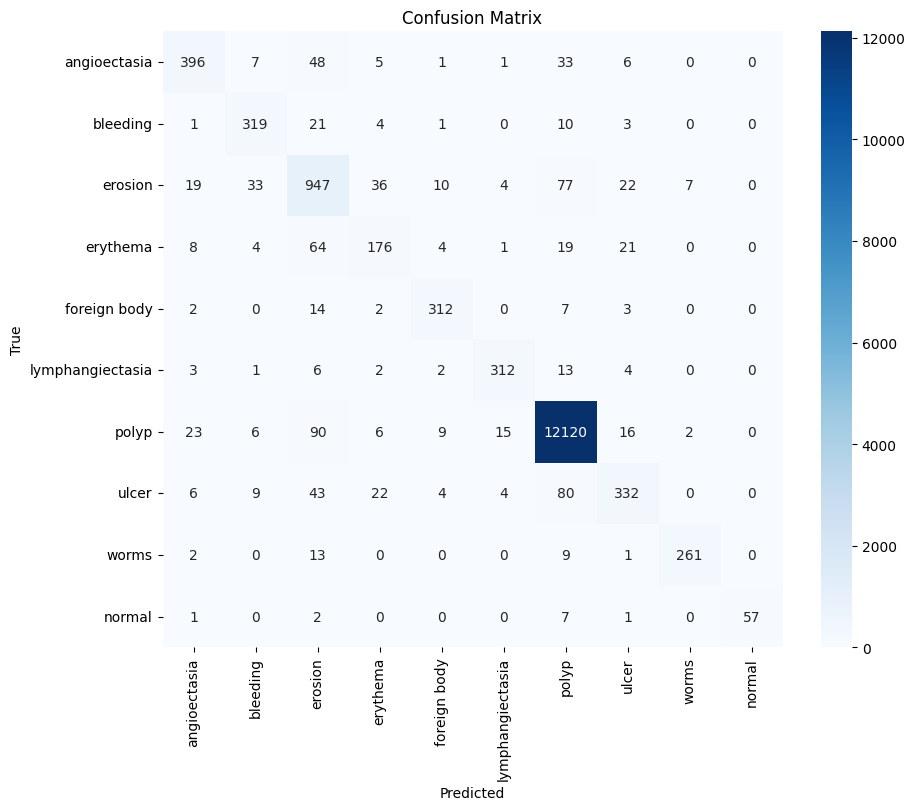

In [36]:
import seaborn as sns
class_names = [
    'angioectasia', 
    'bleeding', 
    'erosion', 
    'erythema', 
    'foreign body', 
    'lymphangiectasia', 
    'polyp', 
    'ulcer', 
    'worms', 
    'normal'
]
cm = conf_matrix


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
